In [1]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/feyzazkefe/trashnet/code")

Skipping, found downloaded files in "./trashnet" (use force=True to force download)


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision import models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = []
labels = []

for label in os.listdir("/content/trashnet/dataset-resized"):
    for img in os.listdir(f"/content/trashnet/dataset-resized/{label}"):
      image_path.append(f"/content/trashnet/dataset-resized/{label}/{img}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
data_df.head()

,image_path,labels
0,/content/trashnet/dataset-resized/cardboard/ca...,cardboard
1,/content/trashnet/dataset-resized/cardboard/ca...,cardboard
2,/content/trashnet/dataset-resized/cardboard/ca...,cardboard
3,/content/trashnet/dataset-resized/cardboard/ca...,cardboard
4,/content/trashnet/dataset-resized/cardboard/ca...,cardboard


In [5]:
data_df["labels"].value_counts()

,count
labels,
paper,594
glass,501
plastic,482
metal,410
cardboard,403
trash,137


In [6]:
def plot_random_images(dataframe, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        random_row = dataframe.sample(n=1).iloc[0]
        img_path = random_row['image_path']
        label = random_row['labels']
        img = Image.open(img_path)

        print(img.size)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


(512, 384)
(512, 384)
(512, 384)
(512, 384)
(512, 384)


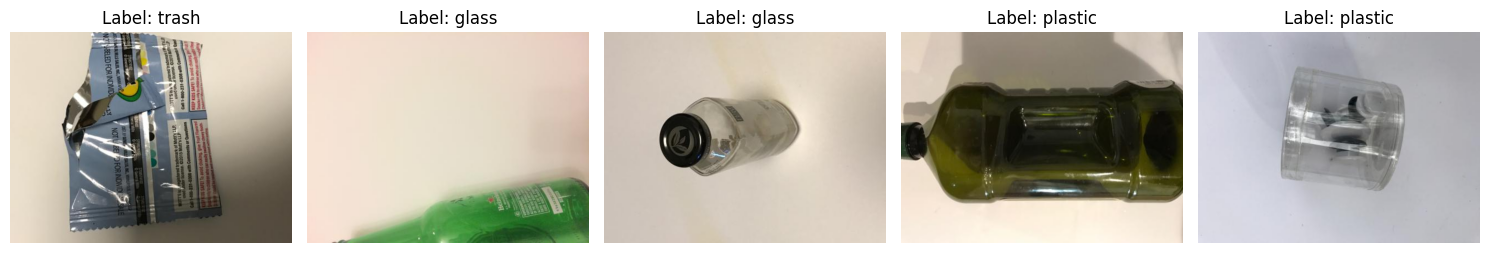

In [7]:
plot_random_images(data_df)

In [8]:
le = LabelEncoder()
data_df["labels_encoded"] = le.fit_transform(data_df["labels"])
data_df.head()

,image_path,labels,labels_encoded
0,/content/trashnet/dataset-resized/cardboard/ca...,cardboard,0
1,/content/trashnet/dataset-resized/cardboard/ca...,cardboard,0
2,/content/trashnet/dataset-resized/cardboard/ca...,cardboard,0
3,/content/trashnet/dataset-resized/cardboard/ca...,cardboard,0
4,/content/trashnet/dataset-resized/cardboard/ca...,cardboard,0


In [9]:
class_names = le.classes_
print("Classes: ", class_names)

Classes:  ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']


In [10]:
train_df, temp_df = train_test_split(data_df, test_size=0.3, stratify=data_df['labels_encoded'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels_encoded'], random_state=42)

In [11]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [12]:
class WasteDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(dataframe["labels_encoded"].values, dtype=torch.long)

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    img_path = self.dataframe.iloc[index]["image_path"]
    label = self.labels[index]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    return image, label

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [14]:
train_dataset = WasteDataset(train_df, transform)
val_dataset = WasteDataset(val_df, transform)
test_dataset = WasteDataset(test_df, transform)

In [15]:
model = models.resnet50(weights='DEFAULT')

In [16]:
# Congelando os pesos, não queremos treinar a rede toda, só a classificação final
for param in model.parameters():
    param.requires_grad = False

In [17]:
num_ftrs = model.fc.in_features
num_ftrs

2048

In [18]:
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 6)
)

In [19]:
model = model.to(device)

In [20]:
train_labels = train_df['labels_encoded'].values

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Ordem das Classes: {le.classes_}")
print(f"Pesos Calculados: {weights_tensor}")

Ordem das Classes: ['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']
Pesos Calculados: tensor([1.0449, 0.8419, 1.0267, 0.7083, 0.8744, 3.0694], device='cuda:0')


In [21]:
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

In [22]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [23]:
if not os.path.exists('models'):
    os.makedirs('models')

In [24]:
total_loss_train = []
total_acc_train = []
total_loss_val = []
total_acc_val = []

best_acc = 0.0
patience_counter = 0
PATIENCE = 5
EPOCHS = 25


for epoch in range(EPOCHS):
  train_loss = 0
  train_acc = 0
  model.train()

  loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

  for images, labels in loop:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * images.size(0) # Multiplica pelo tamanho do batch para média ponderada correta
    _, preds = torch.max(output, 1)
    train_acc += (preds == labels).sum().item()

    loop.set_postfix(loss=loss.item())

  model.eval()
  val_loss = 0
  val_correct = 0

  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = criterion(output, labels)

      val_loss += loss.item() * images.size(0)
      _, preds = torch.max(output, 1)
      val_correct += (preds == labels).sum().item()

  avg_train_loss = train_loss / len(train_dataset)
  avg_train_acc = (train_acc / len(train_dataset)) * 100

  avg_val_loss = val_loss / len(val_dataset)
  avg_val_acc = (val_correct / len(val_dataset)) * 100

  total_loss_train.append(avg_train_loss)
  total_acc_train.append(avg_train_acc)
  total_loss_val.append(avg_val_loss)
  total_acc_val.append(avg_val_acc)

  if avg_val_acc > best_acc:
    best_acc = avg_val_acc
    patience_counter = 0
    torch.save(model.state_dict(), 'models/best_model.pth')
    print(f" -> Modelo Salvo! Nova Best Acc: {best_acc:.2f}%")
  else:
    patience_counter += 1
    if patience_counter >= PATIENCE:
      print("Early stopping triggered")
      break

  print(f" -> Train Acc: {avg_train_acc:.2f}% | Val Acc: {avg_val_acc:.2f}% | Val Loss: {avg_val_loss:.4f}")


Epoch 1/25: 100%|██████████| 56/56 [00:12<00:00,  4.40it/s, loss=0.854]


 -> Modelo Salvo! Nova Best Acc: 83.64%
 -> Train Acc: 68.61% | Val Acc: 83.64% | Val Loss: 0.5369


Epoch 2/25: 100%|██████████| 56/56 [00:11<00:00,  4.68it/s, loss=0.392]


 -> Modelo Salvo! Nova Best Acc: 87.34%
 -> Train Acc: 85.46% | Val Acc: 87.34% | Val Loss: 0.3979


Epoch 3/25: 100%|██████████| 56/56 [00:08<00:00,  6.99it/s, loss=0.233]


 -> Modelo Salvo! Nova Best Acc: 87.60%
 -> Train Acc: 88.86% | Val Acc: 87.60% | Val Loss: 0.4593


Epoch 4/25: 100%|██████████| 56/56 [00:10<00:00,  5.51it/s, loss=0.298]


 -> Train Acc: 92.82% | Val Acc: 87.34% | Val Loss: 0.3965


Epoch 5/25: 100%|██████████| 56/56 [00:09<00:00,  5.65it/s, loss=0.362]


 -> Train Acc: 93.83% | Val Acc: 87.07% | Val Loss: 0.3865


Epoch 6/25: 100%|██████████| 56/56 [00:06<00:00,  8.12it/s, loss=0.11]


 -> Modelo Salvo! Nova Best Acc: 87.86%
 -> Train Acc: 95.14% | Val Acc: 87.86% | Val Loss: 0.3920


Epoch 7/25: 100%|██████████| 56/56 [00:07<00:00,  7.88it/s, loss=0.18]


 -> Train Acc: 96.32% | Val Acc: 87.86% | Val Loss: 0.3811


Epoch 8/25: 100%|██████████| 56/56 [00:08<00:00,  7.00it/s, loss=0.181]


 -> Train Acc: 97.57% | Val Acc: 87.34% | Val Loss: 0.3678


Epoch 9/25: 100%|██████████| 56/56 [00:07<00:00,  7.14it/s, loss=0.023]


 -> Modelo Salvo! Nova Best Acc: 88.13%
 -> Train Acc: 96.38% | Val Acc: 88.13% | Val Loss: 0.4254


Epoch 10/25: 100%|██████████| 56/56 [00:06<00:00,  8.03it/s, loss=0.63]


 -> Modelo Salvo! Nova Best Acc: 88.39%
 -> Train Acc: 97.96% | Val Acc: 88.39% | Val Loss: 0.3780


Epoch 11/25: 100%|██████████| 56/56 [00:07<00:00,  7.13it/s, loss=0.39]


 -> Modelo Salvo! Nova Best Acc: 88.65%
 -> Train Acc: 96.61% | Val Acc: 88.65% | Val Loss: 0.3822


Epoch 12/25: 100%|██████████| 56/56 [00:11<00:00,  4.87it/s, loss=0.0463]


 -> Train Acc: 97.74% | Val Acc: 88.39% | Val Loss: 0.3908


Epoch 13/25: 100%|██████████| 56/56 [00:07<00:00,  7.03it/s, loss=0.00652]


 -> Modelo Salvo! Nova Best Acc: 89.97%
 -> Train Acc: 98.59% | Val Acc: 89.97% | Val Loss: 0.4049


Epoch 14/25: 100%|██████████| 56/56 [00:07<00:00,  7.00it/s, loss=0.349]


 -> Train Acc: 98.76% | Val Acc: 88.39% | Val Loss: 0.3841


Epoch 15/25: 100%|██████████| 56/56 [00:08<00:00,  6.82it/s, loss=0.328]


 -> Train Acc: 97.68% | Val Acc: 88.92% | Val Loss: 0.3735


Epoch 16/25: 100%|██████████| 56/56 [00:07<00:00,  7.96it/s, loss=0.963]


 -> Train Acc: 97.68% | Val Acc: 88.13% | Val Loss: 0.4289


Epoch 17/25: 100%|██████████| 56/56 [00:08<00:00,  6.80it/s, loss=0.0434]


 -> Train Acc: 98.47% | Val Acc: 87.07% | Val Loss: 0.4661


Epoch 18/25: 100%|██████████| 56/56 [00:08<00:00,  6.90it/s, loss=0.0591]


Early stopping triggered


[[57  1  1  1  0  0]
 [ 0 69  3  0  4  0]
 [ 0  5 54  0  2  1]
 [ 4  0  1 80  1  3]
 [ 0  3  3  1 66  0]
 [ 0  0  0  1  1 18]]


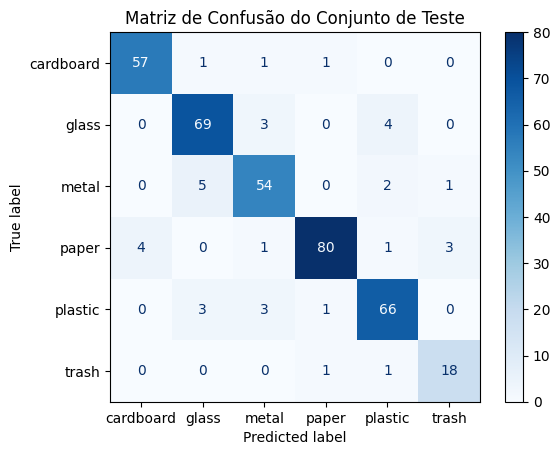

Acurácia Final no Teste: 90.53%


In [30]:
model.load_state_dict(torch.load('models/best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    _, preds = torch.max(output, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

print(cm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão do Conjunto de Teste')
plt.show()

final_test_acc = (np.array(all_preds) == np.array(all_labels)).sum() / len(test_dataset) * 100
print(f"Acurácia Final no Teste: {final_test_acc:.2f}%")

In [ ]:
def predict_waste(image_path, model, transform, class_names, device):
    model.eval()

    try:
        image = Image.open(image_path).convert('RGB')

        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

        image_tensor = transform(image).unsqueeze(0)
        image_tensor = image_tensor.to(device)

        with torch.no_grad():
            outputs = model(image_tensor)

            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted_idx = torch.max(probs, 1)

            predicted_label = class_names[predicted_idx.item()]
            conf_percent = confidence.item() * 100

        print(f"\n♻️ Classificação: **{predicted_label.upper()}**")
        print(f"📊 Confiança: {conf_percent:.2f}%")

        if conf_percent < 60:
            print("CUIDADO: O modelo está incerto. Talvez a imagem esteja fora do padrão.")

        return predicted_label

    except Exception as e:
        print(f"Erro ao processar imagem: {e}")

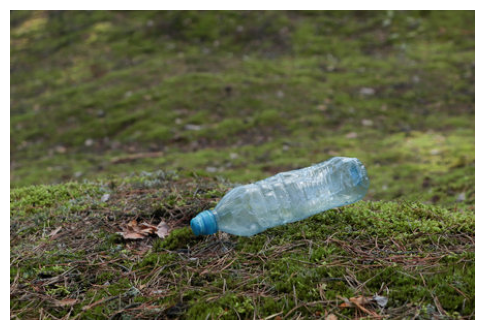


♻️ Classificação: **PLASTIC**
📊 Confiança: 97.83%


'plastic'

In [ ]:
predict_waste("assets/garrafa_de_plastico.jpg", model, val_loader.dataset.transform, class_names, device)

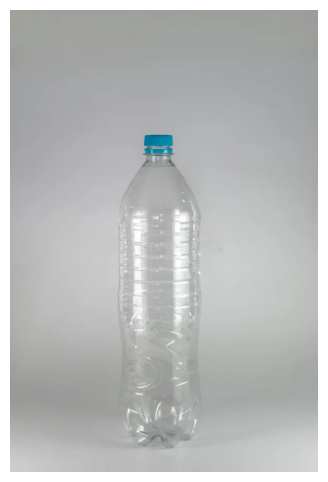


♻️ Classificação: **PLASTIC**
📊 Confiança: 100.00%


'plastic'

In [ ]:
predict_waste("assets/garrafa_de_plastico_fundo_branco.webp", model, val_loader.dataset.transform, class_names, device)

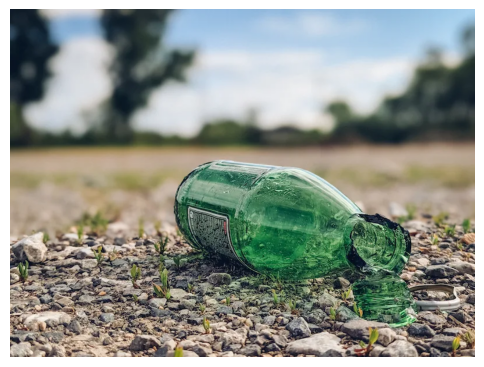


♻️ Classificação: **PLASTIC**
📊 Confiança: 83.87%


'plastic'

In [ ]:
predict_waste("assets/garrafa_de_vidro.webp", model, val_loader.dataset.transform, class_names, device)

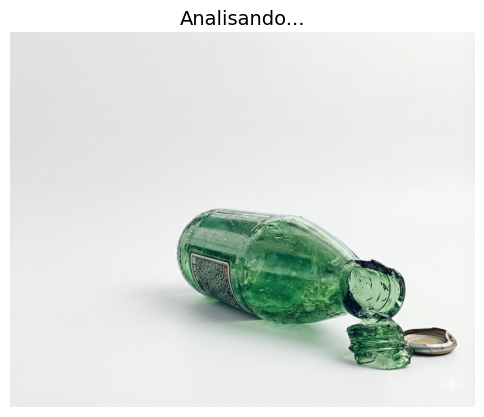


♻️ Classificação: **GLASS**
📊 Confiança: 99.78%


'glass'

In [ ]:
predict_waste("assets/garrafa_de_vidro_fundo_branco.png", model, val_loader.dataset.transform, class_names, device)